In [1]:
import numpy as np
from pathlib import Path
from pycorr import TwoPointCorrelationFunction
import matplotlib.pyplot as plt
import sys 
import jax
from datasets import nbody_dataset 
sys.path.append("../")

2023-11-22 10:13:01.862737: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/sw/helmod-rocky8/apps/Core/cuda/12.0.1-fasrc01/cuda/extras/CUPTI/lib64:/n/sw/helmod-rocky8/apps/Core/cuda/12.0.1-fasrc01/cuda/lib64:/n/sw/helmod-rocky8/apps/Core/cuda/12.0.1-fasrc01/cuda/lib:/n/sw/helmod-rocky8/apps/Core/gcc/12.2.0-fasrc01/lib64:/n/sw/helmod-rocky8/apps/Core/gcc/12.2.0-fasrc01/lib:/n/sw/helmod-rocky8/apps/Core/mpc/1.3.1-fasrc01/lib64:/n/sw/helmod-rocky8/apps/Core/mpfr/4.2.0-fasrc01/lib64:/n/sw/helmod-rocky8/apps/Core/gmp/6.2.1-fasrc01/lib64
2023-11-22 10:13:08.894477: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/sw/helmod-rock

In [2]:
jax.devices()

I0000 00:00:1700666003.377409 2426340 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[gpu(id=0)]

In [3]:
%matplotlib inline

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

from matplotlib import cm
cmap = plt.cm.get_cmap('viridis_r')
#cmap = matplotlib.colormaps.get_cmap('viridis_r')

# Ignore warning
import warnings
import logging

logging.getLogger('matplotlib').setLevel(logging.ERROR)
warnings.filterwarnings("ignore",category=matplotlib.MatplotlibDeprecationWarning)

# Get plot params

from plot_params import params
pylab.rcParams.update(params)

# Set default colors to load at will
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [52]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [42]:
boxsize = 1000.
r_bins = np.linspace(0.5, 150.0, 25)
k_values = [1,5,9]
r_c = 0.5*(r_bins[1:] + r_bins[:-1])
mu_bins = np.linspace(-1, 1, 201)
n = 50 

data_dir = Path('/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-data/')
test_halos = np.load(data_dir / 'test_halos_fiducial.npy')[:n,:,:]
test_halos[...,-1] = np.log10(test_halos[...,-1])

In [7]:
def get_tpcf(pos,):
    return TwoPointCorrelationFunction(
                "smu",
                edges=(np.array(r_bins), np.array(mu_bins)),
                data_positions1=pos.T,
                engine="corrfunc",
                n_threads=2,
                boxsize=boxsize,
                los="z",
    )(ells=[0])[0]

In [8]:
def get_samples_across_checkpoints(path_to_samples, checkpoints):
    generated_samples = []
    for checkpoint in checkpoints:
        generated_samples.append(np.load(path_to_samples / f'fiducial_samples_steps500_checkpoint{checkpoint}.npy')[:n])
    return generated_samples

In [9]:
gnn_pos = 'gallant-cherry-87'
transformer_vel = 'magical-goosebump-109'
n_test = len(test_halos)
path_to_data = Path(f'/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/set_diffuser/samples/')
checkpoints = list(np.arange(5000, 305_000, 10_000)) 
gnn_pos_samples = get_samples_across_checkpoints(
    path_to_data / f'{gnn_pos}', checkpoints,
)
transformer_vel_samples = get_samples_across_checkpoints(
    path_to_data / f'{transformer_vel}', checkpoints,
)



In [10]:
def get_gen_tpcfs(generated_samples):
    test_gen_tpcfs = []
    for samples in generated_samples:
        tpcfs = []
        for hpos in samples:
            tpcfs.append(
                get_tpcf(np.array(hpos[...,:3]))
            )
        test_gen_tpcfs.append(tpcfs)
    return np.array(test_gen_tpcfs)

In [12]:
# compute 2pcfs
test_tpcfs = []
for hpos in test_halos:
    test_tpcfs.append(
        get_tpcf(hpos[...,:3])
    )
test_tpcfs = np.array(test_tpcfs)
gnn_pos_tpcfs =get_gen_tpcfs(gnn_pos_samples) 
transformer_vel_tpcfs =get_gen_tpcfs(transformer_vel_samples) 


In [13]:

import jax.numpy as jnp
from jax.scipy.linalg import inv, det

def kl_divergence_gaussian(samples_P, samples_Q, lambda_reg=1.e-6,):
    """
    Compute KL divergence between two multivariate Gaussians using samples.

    Args:
        samples_P, samples_Q: Samples from distributions P and Q. Each should be 
        a 2D array with shape [num_samples, dimensionality].

    Returns:
        KL divergence between the Gaussians estimated from the samples.
    """
    mu_P = jnp.mean(samples_P, axis=0)
    mu_Q = jnp.mean(samples_Q, axis=0)
    
    Sigma_P = jnp.cov(samples_P.T)  + lambda_reg * jnp.eye(mu_P.shape[0])
    Sigma_Q = jnp.cov(samples_Q.T) + lambda_reg * jnp.eye(mu_Q.shape[0])
    # Inverse of Sigma_Q
    inv_Sigma_Q = inv(Sigma_Q)
    
    # Difference in means
    delta_mu = mu_Q - mu_P

    # Main computations for the KL divergence
    term1 = jnp.trace(jnp.dot(inv_Sigma_Q, Sigma_P))
    term2 = jnp.dot(delta_mu.T, jnp.dot(inv_Sigma_Q, delta_mu))
    term3 = jnp.log(det(Sigma_Q) / det(Sigma_P))
    
    k = mu_P.shape[0]  # dimensionality

    # Put everything together
    kl_div = 0.5 * (term1 + term2 - k + term3)
    
    return kl_div

def get_kl(true, sampled, r_max=55.):
    kl_divergence = []
    for i, sample in enumerate(sampled):
        kl_divergence.append(kl_divergence_gaussian(true[:,r_c < r_max], sample[:,r_c < r_max])) 
    return np.array(kl_divergence)

kl_gnn_pos = get_kl(test_tpcfs, gnn_pos_tpcfs)
kl_transformer_vel = get_kl(test_tpcfs, transformer_vel_tpcfs)

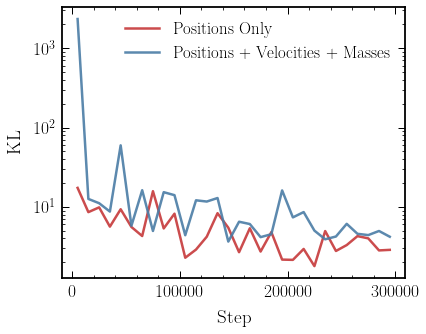

In [14]:
plt.plot(checkpoints, kl_gnn_pos, label='Positions Only')
plt.plot(checkpoints, kl_transformer_vel, label='Positions + Velocities + Masses')
plt.xlabel('Step')
plt.ylabel('KL')
plt.legend()
plt.yscale('log')

In [15]:

from models.diffusion import VariationalDiffusionModel

In [16]:
def get_norm_dict(n_features):
    _, norm_dict = nbody_dataset(
        n_features=n_features,
        n_particles=5_000,
        split="test",
        batch_size=1,
        seed=1,
    )
    return norm_dict

rng = jax.random.PRNGKey(42)
n_steps = 500


norm_dict_pos = get_norm_dict(3)
norm_dict = get_norm_dict(7)


2023-11-22 10:16:31.483441: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/sw/helmod-rocky8/apps/Core/cuda/12.0.1-fasrc01/cuda/extras/CUPTI/lib64:/n/sw/helmod-rocky8/apps/Core/cuda/12.0.1-fasrc01/cuda/lib64:/n/sw/helmod-rocky8/apps/Core/cuda/12.0.1-fasrc01/cuda/lib:/n/sw/helmod-rocky8/apps/Core/gcc/12.2.0-fasrc01/lib64:/n/sw/helmod-rocky8/apps/Core/gcc/12.2.0-fasrc01/lib:/n/sw/helmod-rocky8/apps/Core/mpc/1.3.1-fasrc01/lib64:/n/sw/helmod-rocky8/apps/Core/mpfr/4.2.0-fasrc01/lib64:/n/sw/helmod-rocky8/apps/Core/gmp/6.2.1-fasrc01/lib64
2023-11-22 10:16:31.483517: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /n/sw/helmod-rock

In [43]:

def get_loss_for_model(run_name, test_halos, norm_dict, path_to_models,):
    path_to_model = path_to_models / run_name
    fiducial_cosmology = np.array([0.3175, 0.834])
    fiducial_cosmologies = np.repeat(fiducial_cosmology[None, :], len(test_halos), axis=0)
    test_halos_fiducial = (test_halos - norm_dict['mean']) / norm_dict['std']
    loss = []
    for checkpoint in checkpoints:
        vdm, params = VariationalDiffusionModel.from_path_to_model(
            path_to_model=path_to_model,
            checkpoint_step=checkpoint,
        )
        loss_diff, loss_klz, loss_recon = vdm.apply(
                params,
                test_halos_fiducial,
                fiducial_cosmologies,
                np.ones_like(test_halos_fiducial[..., 0]),
                rngs={'sample':rng},
            )
        l = (loss_diff.sum((-1)) + loss_klz.sum((-1)) + loss_recon.sum((-1))).mean()
        loss.append(l)
    return loss

In [18]:
path_to_models = Path(
    f"/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-checkpoints/cosmology/"
)
loss_pos = get_loss_for_model(gnn_pos, test_halos[...,:3], norm_dict_pos, path_to_models)

5000
15000
25000
35000
45000
55000
65000
75000
85000
95000
105000
115000
125000
135000
145000
155000
165000
175000
185000
195000
205000
215000
225000
235000
245000
255000
265000
275000
285000
295000


In [24]:
del gnn_pos_samples

In [25]:
del transformer_vel_samples 

In [44]:

loss_vel = get_loss_for_model(transformer_vel, test_halos[:10], norm_dict, path_to_models)

5000
l =  5.6582813
15000
l =  4.291239
25000
l =  4.117727
35000
l =  4.0355587
45000
l =  4.0042067
55000
l =  3.934004
65000
l =  3.8818321
75000
l =  3.8591292
85000
l =  3.8393161
95000
l =  3.8094194
105000
l =  3.7867086
115000
l =  3.7809248
125000
l =  3.7566123
135000
l =  3.746284
145000
l =  3.7457786
155000
l =  3.7280188
165000
l =  3.7210119
175000
l =  3.7025087
185000
l =  3.6885223
195000
l =  3.6762602
205000
l =  3.678028
215000
l =  3.6637096
225000
l =  3.6524942
235000
l =  3.6444108
245000
l =  3.6360269
255000
l =  3.634382
265000
l =  3.6274245
275000
l =  3.6275501
285000
l =  3.6267314
295000
l =  3.6246405


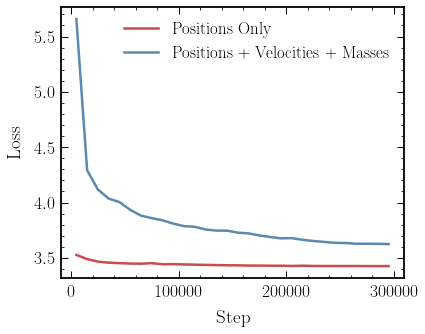

In [45]:
plt.plot(checkpoints, loss_pos, label='Positions Only')
plt.plot(checkpoints, loss_vel, label='Positions + Velocities + Masses')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

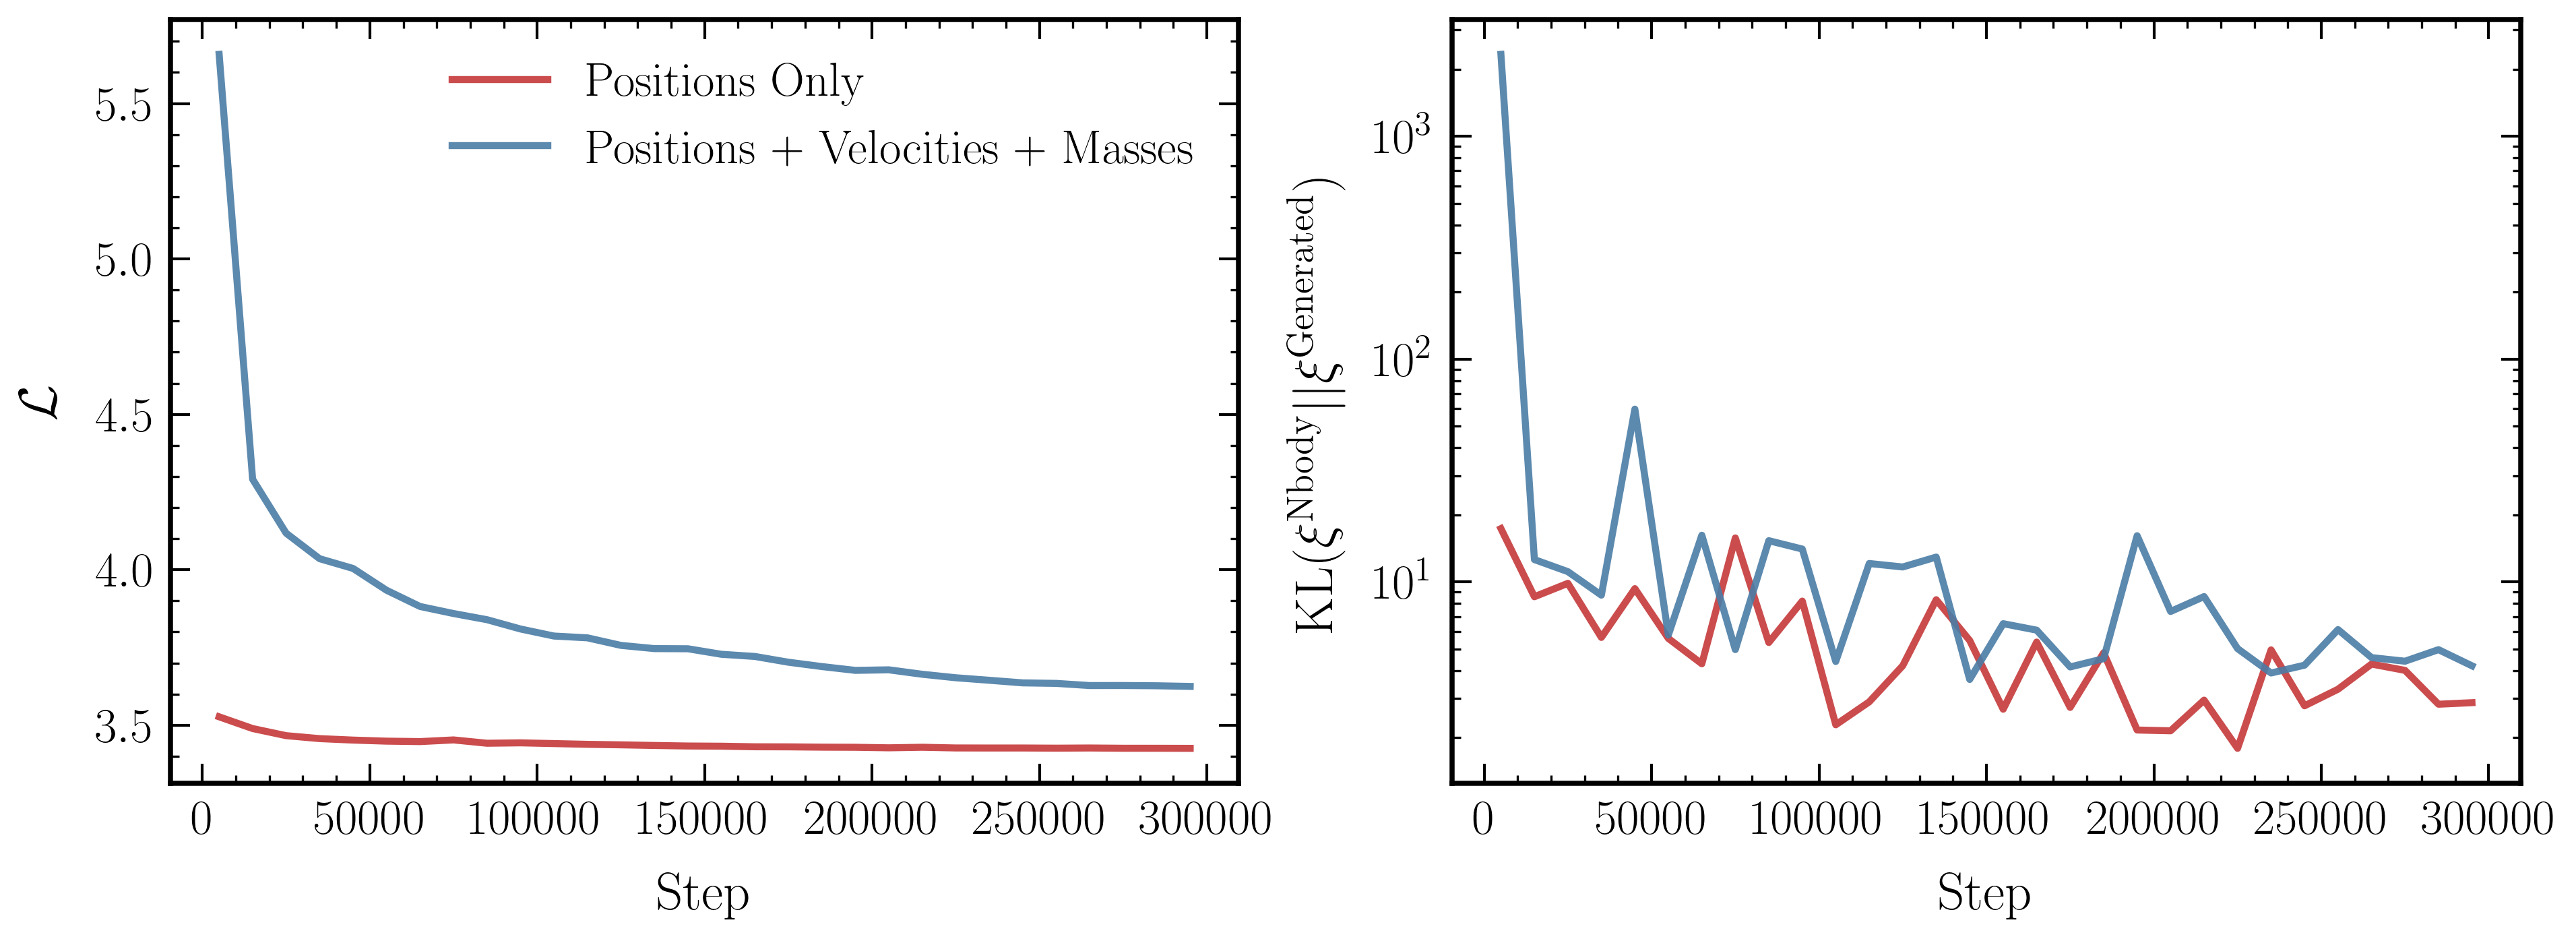

In [56]:
fig, ax = plt.subplots(ncols=2, sharex=True, figsize=(15,5))

ax[0].plot(checkpoints, loss_pos, label='Positions Only')
ax[0].plot(checkpoints, loss_vel, label='Positions + Velocities + Masses')
ax[0].set_xlabel('Step')
ax[0].set_ylabel(r'$\mathcal{L}$')
ax[0].legend()


ax[1].plot(checkpoints, kl_gnn_pos, label='Positions Only')
ax[1].plot(checkpoints, kl_transformer_vel, label='Positions + Velocities + Masses')
ax[1].set_xlabel('Step')
ax[1].set_ylabel(r'$\mathrm{KL}(\xi^\mathrm{Nbody}||\xi^\mathrm{Generated})$')
ax[1].set_yscale('log')

plt.savefig('plots/training_dynamics.pdf', bbox_inches='tight', )